# UNet Fine Tuning

## Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F

from skimage.metrics import structural_similarity as ssim

from PIL import Image
import os
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"On Device: {device}")

On Device: cuda


### Drive Mount

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Defining Dataset and DataLoader

In [3]:
train_path_list = []
test_path_list = []

In [4]:
# train data path list
clean_train_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train'))
blurred_train_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_train'))

for clean, blur in zip(clean_train_paths, blurred_train_paths):
    train_path_list.append([
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train', clean),
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_train', blur)
    ])

# test data path list
clean_test_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/test'))
blurred_test_paths = sorted(os.listdir('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_test'))

for clean, blur in zip(clean_test_paths, blurred_test_paths):
    test_path_list.append([
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/test', clean),
        os.path.join('/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_test', blur)
    ])

In [5]:
# defining dataset
class dataset(Dataset):

  def __init__(self, img_list, data_transform):
    super().__init__()
    self.input = img_list
    self.transforms = data_transform

  def __len__(self):
    return len(self.input)

  def __getitem__(self, idx):
    target_img = Image.open(self.input[idx][0]).convert("RGB")
    train_img = Image.open(self.input[idx][1]).convert("RGB")

    target_img = self.transforms(target_img)
    train_img = self.transforms(train_img)

    return train_img, target_img

In [6]:
img_transforms = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.1317, 0.1317, 0.1318]), torch.tensor([0.2261, 0.2261, 0.2261]))
])

In [7]:
train_data = dataset(train_path_list, img_transforms)
test_data = dataset(test_path_list, img_transforms)

In [8]:
len(train_data), len(test_data)

(5235, 36)

In [9]:
BATCH_SIZE = 32
RANDOM_SEED = 42

torch.cuda.manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# defining dataloader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

In [10]:
len(train_dataloader), len(test_dataloader)

(164, 2)

## Training

In [42]:
%cd /content/drive/MyDrive/Restoring\ Brain\ CT\ and\ Brain\ MRI/
from model_trainer import train

/content/drive/MyDrive/Restoring Brain CT and Brain MRI


In [43]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [44]:
model.conv = nn.Conv2d(32, 3, kernel_size=(1, 1), stride = (1, 1)).to(device)

In [45]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [46]:
# loading model trained for 70 epochs
model.load_state_dict(torch.load("/content/drive/MyDrive/Restoring Brain CT and Brain MRI/models/UNet_L2Loss/unet_epoch70.pth"))

model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [47]:
class L1SSIMPerceptualLoss(nn.Module):
    def __init__(self, ssim_weight=0.3, perceptual_weight=0.1, device='cuda'):
        super(L1SSIMPerceptualLoss, self).__init__()
        self.l1 = nn.L1Loss()
        self.ssim_weight = ssim_weight
        self.perceptual_weight = perceptual_weight

        # Load pretrained VGG-16
        vgg = models.vgg16(pretrained=True).features[:16].eval().to(device)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.device = device

    def compute_ssim(self, pred, target):
        B = pred.shape[0]
        total_ssim = 0.0

        for i in range(B):
            pred_np = pred[i].detach().cpu().numpy()
            target_np = target[i].detach().cpu().numpy()

            pred_img = np.transpose(pred_np, (1, 2, 0)).clip(0, 1)
            target_img = np.transpose(target_np, (1, 2, 0)).clip(0, 1)

            ssim_val = ssim(pred_img, target_img, data_range=4.42, channel_axis=2)
            total_ssim += ssim_val

        return 1.0 - (total_ssim / B)

    def perceptual_loss(self, pred, target):
        # Resize to 224x224
        pred_resized = F.interpolate(pred, size=(224, 224), mode='bilinear', align_corners=False)
        target_resized = F.interpolate(target, size=(224, 224), mode='bilinear', align_corners=False)

        pred_vgg = self.vgg(pred_resized)
        target_vgg = self.vgg(target_resized)

        return F.l1_loss(pred_vgg, target_vgg)

    def forward(self, pred, target):
        pred = pred.to(self.device)
        target = target.to(self.device)

        l1_loss = self.l1(pred, target)
        ssim_loss = self.compute_ssim(pred, target)
        ssim_loss = torch.tensor(ssim_loss, device=self.device)
        perceptual = self.perceptual_loss(pred, target)

        total_loss = (
            (1 - self.ssim_weight - self.perceptual_weight) * l1_loss +
            self.ssim_weight * ssim_loss +
            self.perceptual_weight * perceptual
        )

        return total_loss

In [48]:
loss_fn = L1SSIMPerceptualLoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = 0.0001)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=1.0, total_iters=10)

In [49]:
folder_path = "/content/drive/MyDrive/Restoring Brain CT and Brain MRI/epochs_output/unet_custom_loss/unet1/" # saving first test image's output after every epoch
EPOCHS1 = 5

train_loss1, test_loss1, test_ssim1, test_psnr1 = train(model,
                                                        optimizer,
                                                        loss_fn,
                                                        scheduler,
                                                        train_dataloader,
                                                        test_dataloader,
                                                        EPOCHS1,
                                                        test_path_list,
                                                        img_transforms,
                                                        device,
                                                        save_output_path = folder_path
                                                        )

  0%|          | 0/5 [00:00<?, ?it/s]

===EPOCH: 1===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.51993 | Test Loss: 0.52597 | Test SSIM: 14.92300 | Test PSNR: 0.02265

===EPOCH: 2===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.51868 | Test Loss: 0.52970 | Test SSIM: 14.84530 | Test PSNR: 0.01961

===EPOCH: 3===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.51802 | Test Loss: 0.52899 | Test SSIM: 14.87223 | Test PSNR: 0.01973

===EPOCH: 4===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784555ca9da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784555ca9da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.51755 | Test Loss: 0.52849 | Test SSIM: 14.87782 | Test PSNR: 0.01995

===EPOCH: 5===

Training...



  0%|          | 0/164 [00:00<?, ?it/s]

Testing...



  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: 0.51666 | Test Loss: 0.52915 | Test SSIM: 14.86211 | Test PSNR: 0.01931


Train time on cuda: 1277.821 seconds


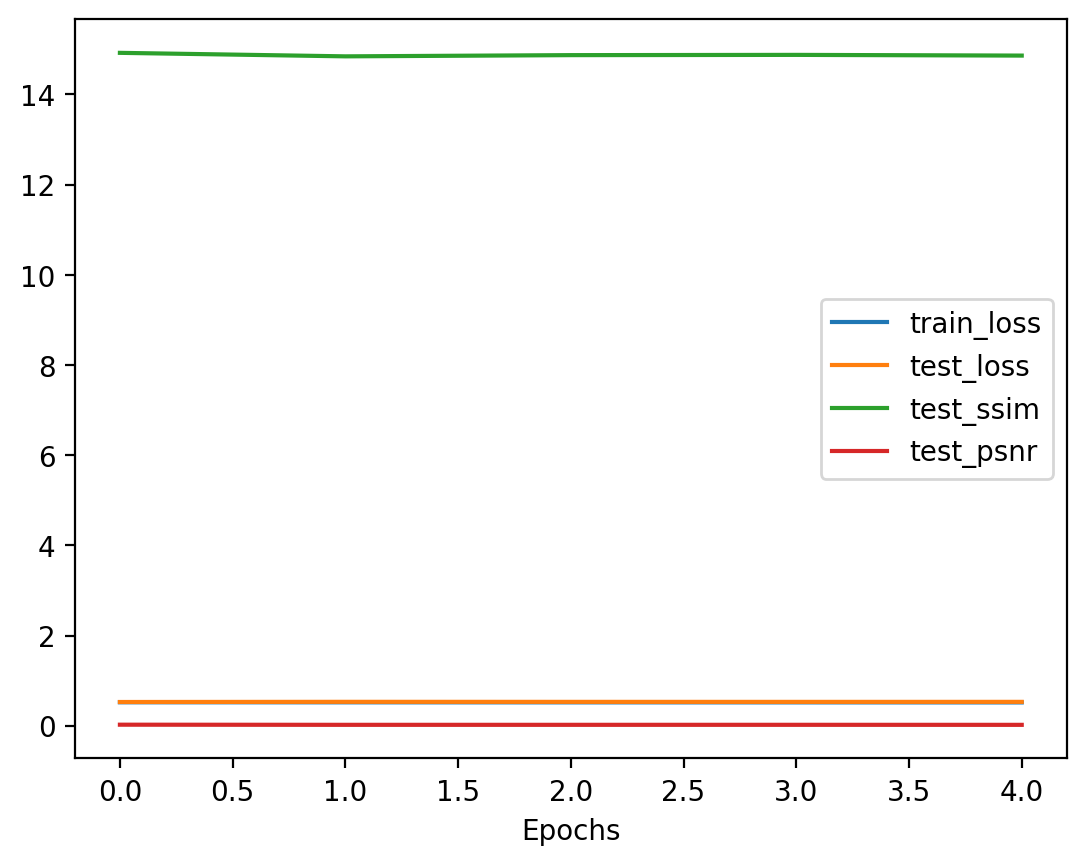

In [50]:
plt.plot(train_loss1, label='train_loss')
plt.plot(test_loss1, label='test_loss')
plt.plot(test_ssim1, label='test_ssim')
plt.plot(test_psnr1, label='test_psnr')

plt.xlabel("Epochs")
plt.legend()
plt.show()

In [51]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("/content/drive/MyDrive/Restoring Brain CT and Brain MRI/models/UNet_Custom_Loss")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "unet_epoch05.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)
print("Done!")

Saving model to: /content/drive/MyDrive/Restoring Brain CT and Brain MRI/models/UNet_Custom_Loss/unet_epoch05.pth
Done!
